In this notebook, you should implement a first version of a working machine learning model to predict the age of an Abalone.

A few guidelines:
- The model does not have to be complex. A simple linear regression model is enough.
- You should use MLflow to track your experiments. You can use the MLflow UI to compare your experiments.
- Do not push any MLflow data to the repository. Only the code to run the experiments is interesting and should be pushed.

In [55]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv("../abalone.csv")

print("Dataset shape:", df.shape)
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset shape: (4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [56]:
# 1. Data Preparation
print("=" * 50)
print("DATA PREPARATION")
print("=" * 50)

# Create a copy of the original data
data = df.copy()

# Encode categorical variable 'Sex'
label_encoder = LabelEncoder()
data['Sex_encoded'] = label_encoder.fit_transform(data['Sex'])

# Define features and target
X = data.drop(['Rings', 'Sex'], axis=1)  # Remove target and original categorical column
y = data['Rings']  # Target variable

print("Features used for modeling:")
print(X.columns.tolist())
print(f"\nTarget variable: Rings")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

DATA PREPARATION
Features used for modeling:
['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_encoded']

Target variable: Rings
Features shape: (4177, 8)
Target shape: (4177,)

Training set: 3341 samples
Test set: 836 samples


In [57]:
# 2. Feature Scaling
print("=" * 50)
print("FEATURE SCALING")
print("=" * 50)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed using StandardScaler")
print(f"Training set scaled shape: {X_train_scaled.shape}")
print(f"Test set scaled shape: {X_test_scaled.shape}")

FEATURE SCALING
Feature scaling completed using StandardScaler
Training set scaled shape: (3341, 8)
Test set scaled shape: (836, 8)


In [59]:
# 3. Initialize MLflow Experiment
print("=" * 50)
print("MLFLOW EXPERIMENT SETUP")
print("=" * 50)

# Set experiment name
mlflow.set_experiment("Abalone_Age_Prediction")

print("MLflow experiment 'Abalone_Age_Prediction' is ready!")
print("You can view results using: mlflow ui")

MLFLOW EXPERIMENT SETUP
MLflow experiment 'Abalone_Age_Prediction' is ready!
You can view results using: mlflow ui


In [ ]:
print("=" * 60)
print("MLFLOW TRAINING WITH PROPER CLEANUP")
print("=" * 60)

# cleanup function
def full_cleanup():
    """完整的MLflow清理"""
    import mlflow
    
    cleaned = []
    while mlflow.active_run():
        run = mlflow.active_run()
        run_id = run.info.run_id
        run_name = run.info.run_name or "Unnamed"
        mlflow.end_run()
        cleaned.append((run_id, run_name))
    
    if cleaned:
        print(f"🧹 Cleaned {len(cleaned)} runs:")
        for run_id, run_name in cleaned:
            print(f"   - {run_name} ({run_id[:8]}...)")
    else:
        print("✅ Environment is clean")
    
    return cleaned


cleaned_runs = full_cleanup()

# 4. Model Training with MLflow Tracking
try:
    with mlflow.start_run(run_name="Linear_Regression_Baseline") as run:
        print(f"🎯 Started SINGLE run: {run.info.run_name}")
        print(f"📋 Run ID: {run.info.run_id}")
        
        # Set tags
        mlflow.set_tag("mlflow.source.type", "NOTEBOOK")
        mlflow.set_tag("cleaned_previous_runs", len(cleaned_runs))
        
        # Log parameters
        mlflow.log_params({
            "model_type": "Linear Regression",
            "test_size": 0.2,
            "random_state": 42,
            "scaling": "StandardScaler"
        })
        
        # Train the model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # Log metrics
        mlflow.log_metrics({
            "mse": mse,
            "mae": mae,
            "r2": r2, 
            "rmse": rmse
        })
        
        # Log model
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model"
        )
        
        print("✅ Model training completed in SINGLE run!")
        print(f"📊 Performance - R²: {r2:.4f}, RMSE: {rmse:.4f}")
        
except Exception as e:
    print(f"❌ Error during training: {e}")
    # Ensure cleanup on error 
    if mlflow.active_run():
        mlflow.end_run()

    
    
#mlflow ui --backend-store-uri "file:///D:/X-HEC/ML%20artefact%20project/xhec-mlops-2025-project/notebooks/mlruns"

2025/10/23 11:58:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLFLOW TRAINING WITH PROPER CLEANUP
🧹 Cleaned 1 runs:
   - abundant-cat-882 (db33ff9c...)
🎯 Started SINGLE run: Linear_Regression_Baseline
📋 Run ID: 7dfcadc269b4497a867759cf6967ff56


2025/10/23 11:58:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Model training completed in SINGLE run!
📊 Performance - R²: 0.5323, RMSE: 2.2500


MODEL PERFORMANCE VISUALIZATION


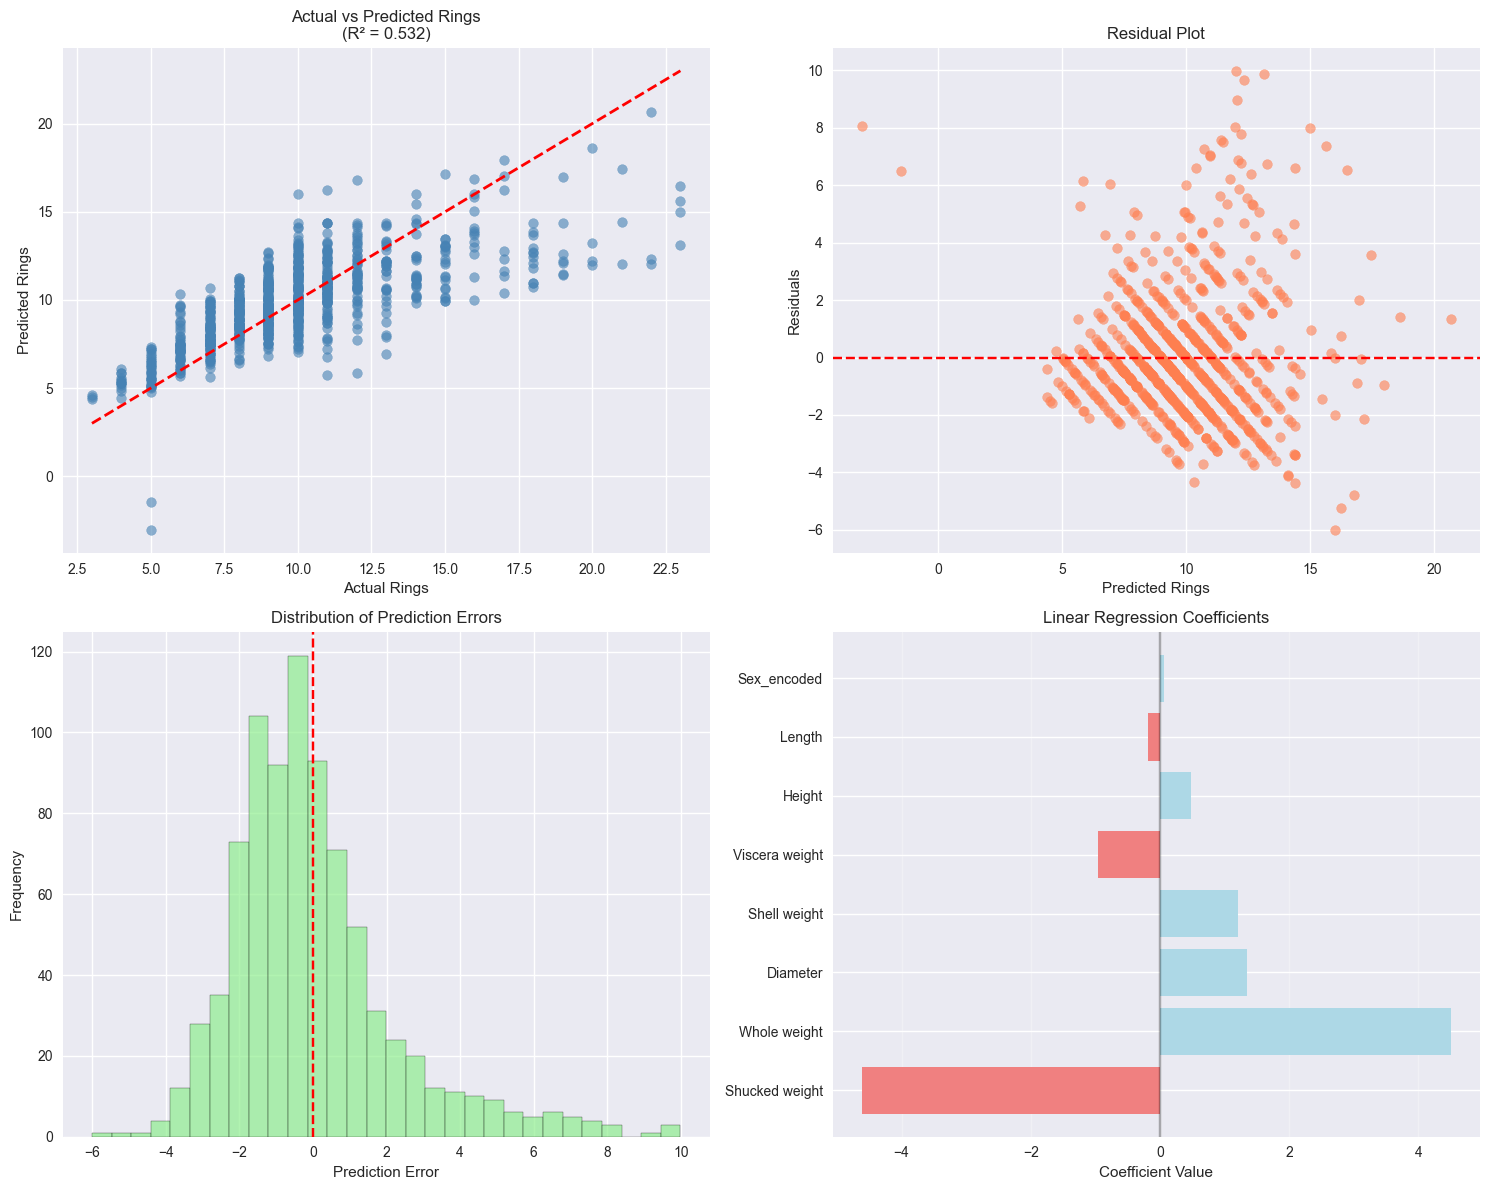

In [64]:
# 5. Model Performance Visualization

print("=" * 50)
print("MODEL PERFORMANCE VISUALIZATION")
print("=" * 50)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted scatter plot
axes[0, 0].scatter(y_test, y_pred, alpha=0.6, color='steelblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Rings')
axes[0, 0].set_ylabel('Predicted Rings')
axes[0, 0].set_title(f'Actual vs Predicted Rings\n(R² = {r2:.3f})')

# 2. Residual plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Rings')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# 3. Error distribution
axes[1, 0].hist(residuals, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')

# 4. Feature importance plot
colors = ['lightblue' if x > 0 else 'lightcoral' for x in feature_importance['coefficient']]
axes[1, 1].barh(feature_importance['feature'], feature_importance['coefficient'], color=colors)
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_title('Linear Regression Coefficients')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Log the visualization
mlflow.log_figure(fig, "model_performance_plots.png")

In [62]:
# 7. Save the Final Model and Artifacts
print("=" * 50)
print("SAVING MODEL AND ARTIFACTS")
print("=" * 50)

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained model
model_path = '../models/linear_regression_abalone.pkl'
joblib.dump(model, model_path)

# Save the scaler
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)

# Save the label encoder
encoder_path = '../models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)

print("✅ Model and artifacts saved:")
print(f"   - Model: {model_path}")
print(f"   - Scaler: {scaler_path}")
print(f"   - Label Encoder: {encoder_path}")

# Log the saved model paths in MLflow
mlflow.log_artifact(model_path)
mlflow.log_artifact(scaler_path)
mlflow.log_artifact(encoder_path)

SAVING MODEL AND ARTIFACTS
✅ Model and artifacts saved:
   - Model: ../models/linear_regression_abalone.pkl
   - Scaler: ../models/scaler.pkl
   - Label Encoder: ../models/label_encoder.pkl
